In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.stats import norm

from copy import deepcopy
import itertools
import random

from collections import OrderedDict


import torch
import torch.nn as nn


from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
from ses_network_3_0 import SESNetwork
#from extraction_works.ses_network_2_0_copy import SESNetwork
from utils import make_input, LatentSpace, get_sample_from_num_swaps, get_cos_sim_np, get_cos_sim_torch, test_network, get_ordered_weights

In [3]:
network_parameters = {}

network_parameters["hebbian_filter"] = False

network_parameters["duration_phase_A"] = 1000
network_parameters["duration_phase_B"] = 1500

network_parameters["sleep_duration_A"] = 10
network_parameters["sleep_duration_B"] = 10
network_parameters["reset_dayly"] = True

network_parameters["regions"] = ["sen", "mtl_sparse", "mtl_dense", "mtl", "ctx"]

network_parameters["mtl_pattern_complete_iterations"] = 10
network_parameters["mtl_dense_pattern_complete_iterations"] = 10
network_parameters["mtl_sparse_pattern_complete_iterations"] = 10
network_parameters["ctx_pattern_complete_iterations"] = 10
network_parameters["mtl_generate_pattern_complete_iterations"] = 15

network_parameters["max_semantic_charge"] = 2

network_parameters["sen_num_subregions"] = 1
network_parameters["sen_size_subregions"] = torch.tensor([100])
network_parameters["sen_sparsity"] = torch.tensor([0.2])
network_parameters["sen_sparsity_sleep"] = torch.tensor([0.2])

network_parameters["ctx_num_subregions"] = 2
network_parameters["ctx_size_subregions"] =  torch.tensor([100, 250])
network_parameters["ctx_sparsity"] = torch.tensor([0.2, 1/25])
network_parameters["ctx_sparsity_sleep"] = torch.tensor([0.1, 1/25])

network_parameters["mtl_num_subregions"] = 2
network_parameters["mtl_size_subregions"] =  torch.tensor([100, 100])
network_parameters["mtl_sparsity"] = torch.tensor([0.2, 0.1])
network_parameters["mtl_sparsity_sleep"] = torch.tensor([0.1, 0.05])

network_parameters["mtl_dense_num_subregions"] = 1
network_parameters["mtl_dense_size_subregions"] = torch.tensor([100])
network_parameters["mtl_dense_sparsity"] = torch.tensor([0.2])
network_parameters["mtl_dense_sparsity_sleep"] = torch.tensor([0.1])

network_parameters["mtl_sparse_num_subregions"] = 1
network_parameters["mtl_sparse_size_subregions"] = torch.tensor([100])
network_parameters["mtl_sparse_sparsity"] = torch.tensor([0.1])
network_parameters["mtl_sparse_sparsity_sleep"] = torch.tensor([0.05])

network_parameters["mtl_dense_sen_projection"] = False
network_parameters["mtl_dense_sen_sparsity"] = 0.5

network_parameters["ctx_mtl_quick_lmbda"] = 1e-2
network_parameters["max_pre_ctx_mtl_quick"] = np.inf
network_parameters["max_post_ctx_mtl_quick"] = 1

network_parameters["ctx_mtl_sparsity"] = 0.5
network_parameters["ctx_mtl_mean"] = 0.03
network_parameters["ctx_mtl_std"] = 0.001
network_parameters["ctx_mtl_lmbda"] = 5e-4
network_parameters["ctx_mtl_size"] = 2
network_parameters["max_pre_ctx_mtl"] = np.inf
network_parameters["max_post_ctx_mtl"] = 1

network_parameters["ctx_mtl_sparse_mean"] = 0.07
network_parameters["ctx_mtl_sparse_std"] = 0.001
network_parameters["ctx_mtl_sparse_lmbda"] = 5e-4
network_parameters["max_pre_ctx_mtl_sparse"] = np.inf
network_parameters["max_post_ctx_mtl_sparse"] = 1

network_parameters["ctx_mtl_dense_sparsity"] = 0.5
network_parameters["ctx_mtl_dense_g"] = 0.01

network_parameters["mtl_mtl_lmbda"] = 5e-3
network_parameters["max_pre_mtl_mtl"] = 1
network_parameters["max_post_mtl_mtl"] = np.inf

network_parameters["mtl_dense_mtl_dense_lmbda"] = 5e-3
network_parameters["max_pre_mtl_dense_mtl_dense"] = 1
network_parameters["max_post_mtl_dense_mtl_dense"] = np.inf

network_parameters["mtl_sparse_mtl_sparse_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_mtl_sparse"] = 1
network_parameters["max_post_mtl_sparse_mtl_sparse"] = np.inf

network_parameters["ctx_ctx_sparsity"] = 0.05
network_parameters["ctx_ctx_g"] = 1e-4
network_parameters["ctx_ctx_lmbda"] = 5e-4
network_parameters["max_pre_ctx_ctx"] = 1
network_parameters["max_post_ctx_ctx"] = np.inf

network_parameters["mtl_sparse_ctx_mean"] = 0.03
network_parameters["mtl_sparse_ctx_std"] = 0.001
network_parameters["mtl_sparse_ctx_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_ctx"] = np.inf
network_parameters["max_post_mtl_sparse_ctx"] = 1


recording_parameters = {}
recording_parameters["regions"] = ["sen", "mtl_hat", "mtl_dense", "mtl_sparse", "mtl_sparse_hat", "mtl", "ctx", "ctx_hat"]
recording_parameters["rate_activity"] = 1
#recording_parameters["connections"] = ["mtl_mtl", "ctx_mtl", "ctx_ctx", "ctx_mtl_quick", "mtl_sparse_ctx"]
recording_parameters["connections"] = ["ctx_mtl_sparse"]
recording_parameters["rate_connectivity"] = 1

In [4]:
input_params = {}
input_params["num_days"] = 2000
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 8

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

'''
latent_specs["num"] = 5
latent_specs["total_sizes"] = [20, 20, 20, 20, 20]
latent_specs["act_sizes"] = [10, 10, 10, 10, 10]
latent_specs["dims"] = [2, 2, 2, 2, 2]
'''

'\nlatent_specs["num"] = 5\nlatent_specs["total_sizes"] = [20, 20, 20, 20, 20]\nlatent_specs["act_sizes"] = [10, 10, 10, 10, 10]\nlatent_specs["dims"] = [2, 2, 2, 2, 2]\n'

In [5]:
def test_network(net, input_params, print_rate=1):
  input, input_episodes, input_latents = make_input(**input_params)
  with torch.no_grad():
    for day in range(input_params["num_days"]):
      if day%print_rate == 0:
        print(day)
      net(input[day], debug=False)
      net.sleep()
  return input, input_episodes, input_latents, net

In [6]:
#latent_specs["prob_list"] = [0.05 if i==j else 0.05/9 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/100 for i in range(10) for j in range(10)]
#latent_specs["prob_list"] = [1/32 for i in range(32)]

latent_specs["prob_list"] = [1/25 for i in range(5) for j in range(5)]
#latent_specs["prob_list"] = [0.1 if i==j else 0.1/4 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)
network = SESNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
#torch.save(network, "network.pt")

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950


In [11]:
torch.save(network, 'network_1500.pt')

In [123]:
network = torch.load('network_1500.pt', weights_only=False)

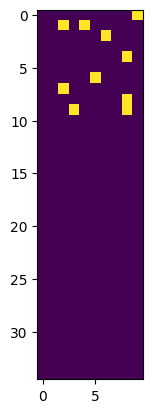

In [33]:
plt.imshow(np.array(network.activity_recordings["ctx"])[network.sleep_indices_A][-1, :].reshape((-1, 10)))

(array([ 20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 230.]),
 array([0.49999997, 0.52099884, 0.54199767, 0.56299657, 0.5839954 ,
        0.6049943 , 0.62599313, 0.64699203, 0.66799086, 0.68898976,
        0.70998859]),
 <BarContainer object of 10 artists>)

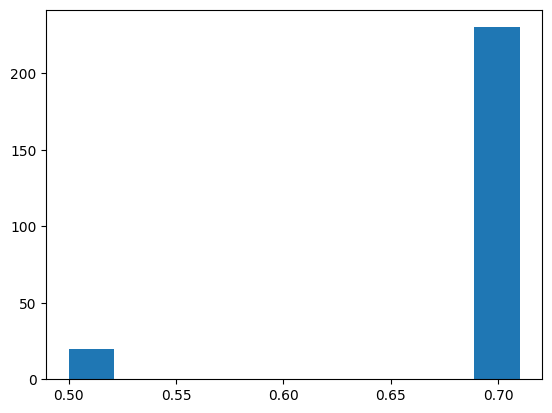

In [46]:
plt.hist(np.array(network.activity_recordings["ctx_hat"])[network.sleep_indices_A][-3, 100:].flatten(), bins=10)

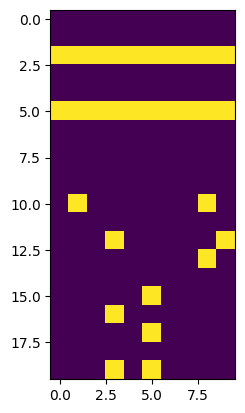

In [27]:
plt.imshow(np.array(network.activity_recordings["mtl"])[network.sleep_indices_A][-3].reshape((-1, 10)))

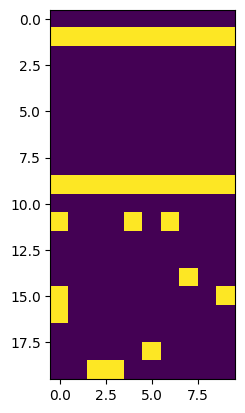

In [70]:
plt.imshow(np.array(network.activity_recordings["mtl"])[network.sleep_indices_A][-8].reshape((-1, 10)))

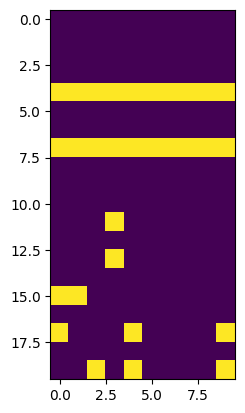

In [118]:
plt.imshow(np.array(network.activity_recordings["mtl"])[network.sleep_indices_A][-8].reshape((-1, 10)))

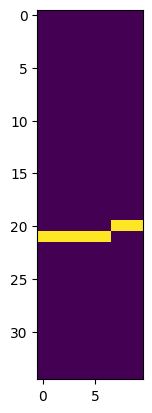

In [116]:
plt.imshow(np.array(network.activity_recordings["ctx"])[network.sleep_indices_A][-8, order_ctx_ctx].reshape(-1, 10))

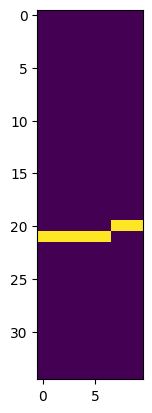

In [117]:
plt.imshow(np.array(network.activity_recordings["ctx"])[network.sleep_indices_A][-3, order_ctx_ctx].reshape(-1, 10))

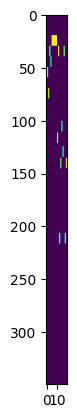

In [115]:
plt.imshow(np.array(network.activity_recordings["ctx"])[network.sleep_indices_A][-20:, order_ctx_ctx].reshape(-1, 350).T)

(array([ 20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  10.,   0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 102.,  98.,   0.,  10.]),
 array([0.        , 0.03333334, 0.06666667, 0.1       , 0.13333334,
        0.16666667, 0.2       , 0.23333333, 0.26666668, 0.30000001,
        0.33333334, 0.36666667, 0.40000001, 0.43333334, 0.46666667,
        0.5       , 0.53333336, 0.56666666, 0.60000002, 0.63333333,
        0.66666669, 0.69999999, 0.73333335, 0.76666665, 0.80000001,
        0.83333331, 0.86666667, 0.89999998, 0.93333334, 0.96666664,
        1.        ]),
 <BarContainer object of 30 artists>)

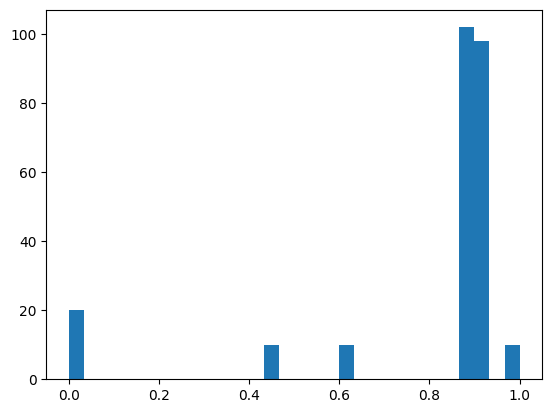

In [72]:
plt.hist(np.array(network.activity_recordings["ctx_hat"])[network.sleep_indices_A][-3, 100:].flatten(), bins=30)

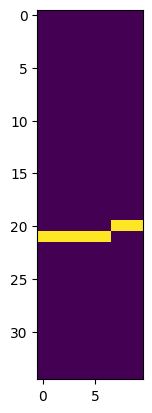

In [67]:
plt.imshow(np.array(network.activity_recordings["ctx"])[network.sleep_indices_A][-3, order_ctx_ctx].reshape(-1, 10))

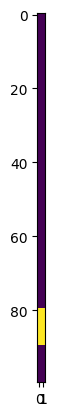

In [28]:
plt.imshow(np.array(network.activity_recordings["ctx"])[network.sleep_indices_B][torch.tensor([-5, -3]), :][:, order_ctx_ctx][:, :100].reshape((-1, 100)).T)

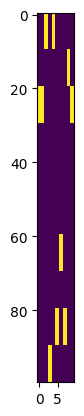

In [26]:
plt.imshow(np.array(network.activity_recordings["ctx"])[network.sleep_indices_B][-10:, :][:, order_ctx_ctx][:, :100].reshape((-1, 100)).T)

In [20]:
np.array(network.activity_recordings["mtl"])[network.sleep_indices_B][-100:].shape

(20, 200)

Text(0.5, 0, 'Time')

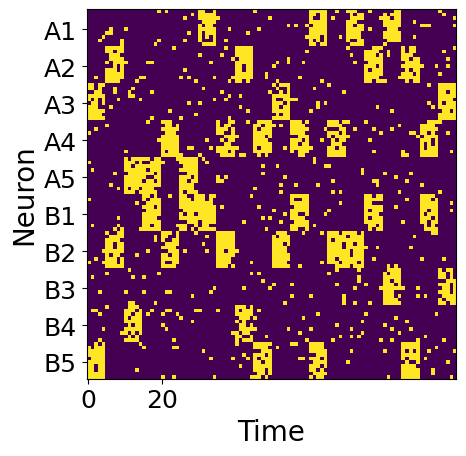

In [16]:
plt.imshow(np.array(network.activity_recordings["mtl"])[network.awake_indices][:100, :100].reshape(-1, 100).T)

# Example parameters
N = 100  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B

# Positions for labels (centered in each segment)
positions = [M * (i + 0.5) for i in range(NA + NB)]
plt.yticks(positions, labels, fontsize=18)
plt.xticks([0, 20], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)

In [7]:
_, order_ctx_ctx, w_ctx_ctx = get_ordered_weights(network.ctx_ctx, order_columns=True)
_, order_mtl_sparse_ctx_A, w_mtl_sparse_ctx = get_ordered_weights(network.mtl_sparse_ctx)
_, order_mtl_sparse_ctx_B, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_mtl_sparse_ctx_C, w_mtl_sparse_ctx = get_ordered_weights(w_mtl_sparse_ctx.T)
_, order_ctx_mtl, w_ctx_mtl = get_ordered_weights(network.ctx_mtl)
_, order_ctx_mtl_sparse_A, w_ctx_mtl_sparse = get_ordered_weights(network.ctx_mtl_sparse)
_, order_ctx_mtl_sparse_B, w_ctx_mtl_sparse = get_ordered_weights(w_ctx_mtl_sparse.T)

Text(0.5, 0, 'Neuron (Pre)')

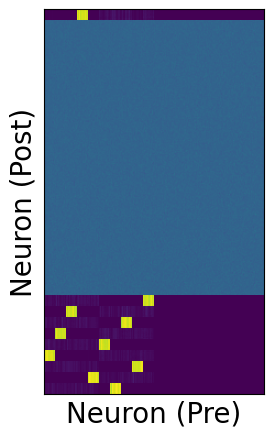

In [8]:
fig = plt.figure(figsize=((5, 5)))
plt.imshow(w_ctx_mtl)
plt.xticks([])
plt.yticks([])
plt.ylabel("Neuron (Post)", fontsize=20)
plt.xlabel("Neuron (Pre)", fontsize=20)

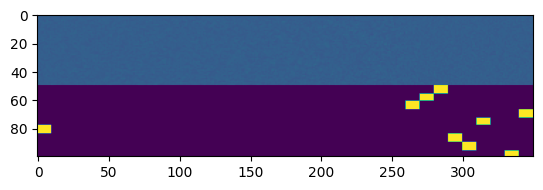

In [9]:
plt.imshow(w_mtl_sparse_ctx)

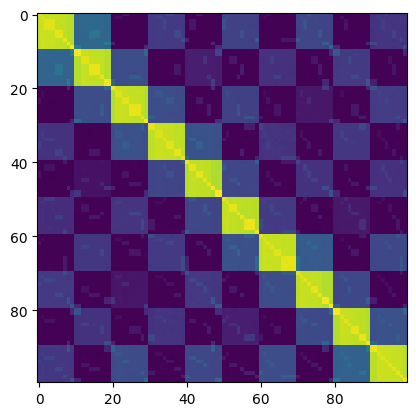

In [10]:
plt.imshow(w_ctx_ctx[:100][:, :100])

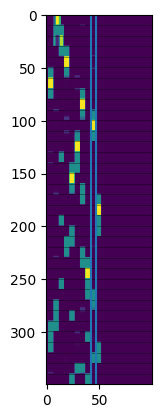

In [11]:
plt.imshow(w_ctx_mtl_sparse.T)
for i in range(35):
  plt.axhline(i*10 - 0.5, linewidth=0.5, color='black', alpha=0.5)
plt.axvline(42)
plt.axvline(47)

TypeError: Invalid shape (100,) for image data

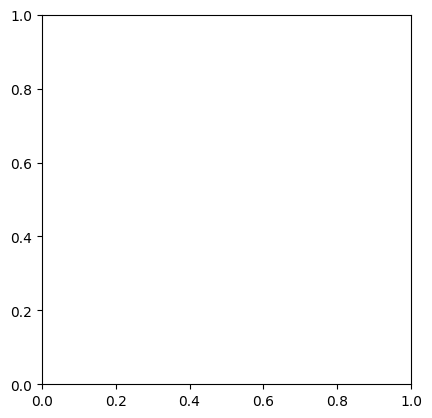

In [ ]:
plt.imshow()

In [7]:
w_recordings = np.array(network.connectivity_recordings["ctx_mtl_sparse"])

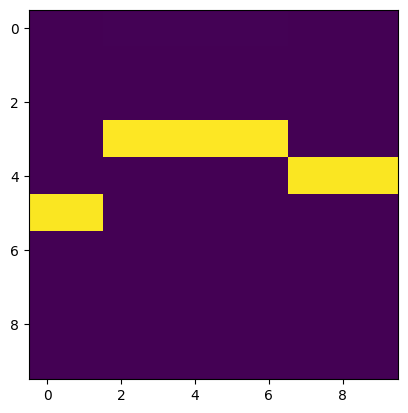

In [41]:
plt.imshow(w_recordings[network.sleep_indices_A][-8000, 110, order_ctx_mtl_sparse].reshape((-1, 10)))

(array([14., 14., 16., 16., 13.,  7.,  4.,  6.,  5.,  5.]),
 array([ 0. ,  9.8, 19.6, 29.4, 39.2, 49. , 58.8, 68.6, 78.4, 88.2, 98. ]),
 <BarContainer object of 10 artists>)

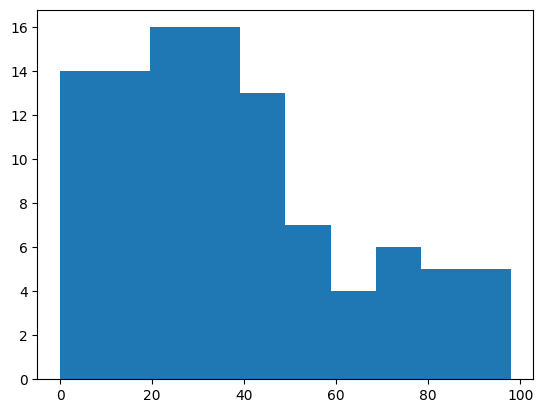

In [51]:
plt.hist(order_ctx_mtl_sparse_B)

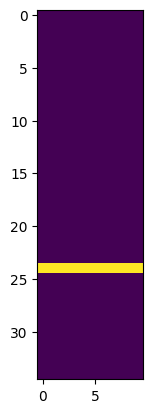

In [93]:
plt.imshow(np.array(network.activity_recordings["ctx"])[network.sleep_indices_A][-9917][order_ctx_mtl_sparse_A].reshape((-1, 10)))

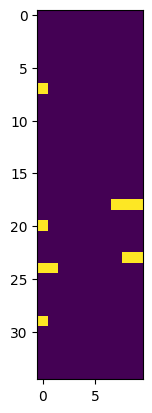

In [137]:
plt.imshow(np.array(network.activity_recordings["ctx"])[network.sleep_indices_A][-198][order_ctx_mtl_sparse_A].reshape((-1, 10)))

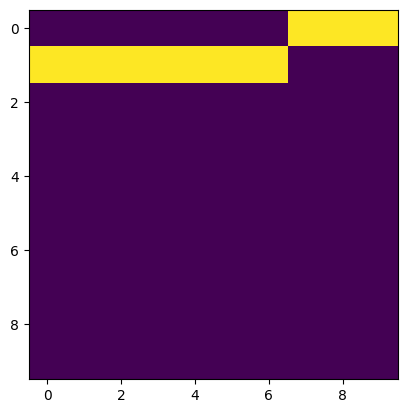

In [139]:
plt.imshow(np.array(network.activity_recordings["mtl_sparse"])[network.sleep_indices_A][-198][order_ctx_mtl_sparse_B].reshape((-1, 10)))

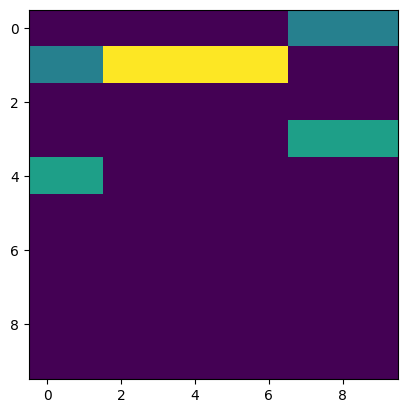

In [118]:
plt.imshow(w_recordings[network.sleep_indices_A][-15][np.ix_(order_ctx_mtl_sparse_A, order_ctx_mtl_sparse_B)][240, :].reshape((-1, 10)))

In [101]:
w_recordings[network.sleep_indices_A][:, np.ix_(order_ctx_mtl_sparse_A, order_ctx_mtl_sparse_B)[0], np.ix_(order_ctx_mtl_sparse_A, order_ctx_mtl_sparse_B)[1]].transpose(1, 2, 0).shape

(350, 100, 25000)

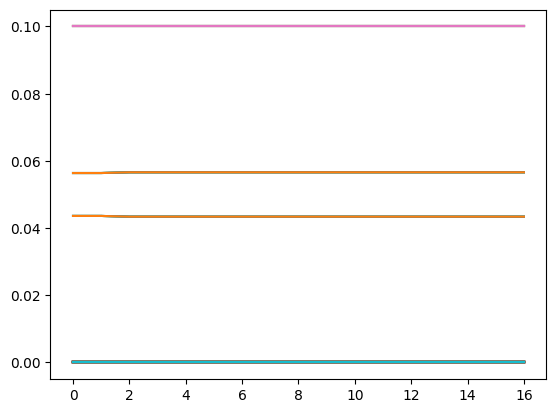

In [126]:
for weight in w_recordings[network.sleep_indices_A][:, np.ix_(order_ctx_mtl_sparse_A, order_ctx_mtl_sparse_B)[0], np.ix_(order_ctx_mtl_sparse_A, order_ctx_mtl_sparse_B)[1]].transpose(1, 2, 0)[240]:
    plt.plot(weight[-17:])
plt.xticksd

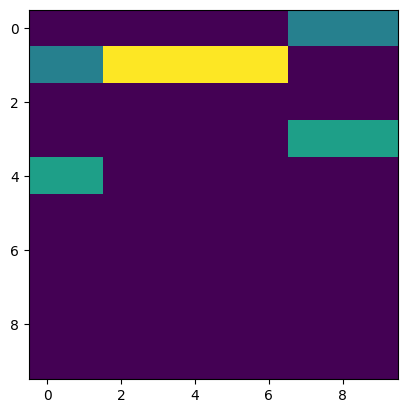

In [60]:
plt.imshow(w_recordings[network.sleep_indices_A][-1][np.ix_(order_ctx_mtl_sparse_A, order_ctx_mtl_sparse_B)][240, :].reshape((-1, 10)))

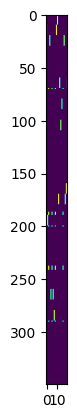

In [134]:
plt.imshow(np.array(network.activity_recordings["ctx"])[network.sleep_indices_A][-200:-180, order_ctx_mtl_sparse_A].reshape(-1, 350).T)

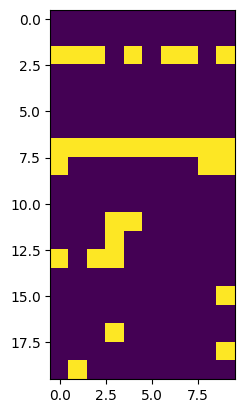

In [28]:
plt.imshow(np.array(network.activity_recordings["mtl"])[network.sleep_indices_A][-15].reshape((-1, 10)))

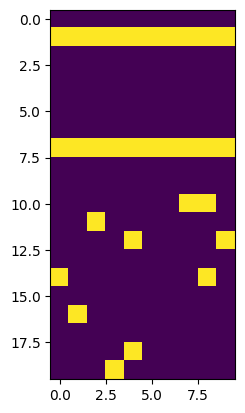

In [28]:
plt.imshow(np.array(network.activity_recordings["mtl"])[network.sleep_indices_A][-10].reshape((-1, 10)))

In [ ]:
plt.imshow(np.array(network.activity_recordings["mtl"])[network.sleep_indices_A][-10].reshape((-1, 10)))

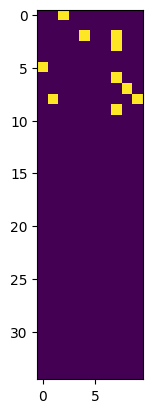

In [24]:
plt.imshow(np.array(network.activity_recordings["ctx"])[network.sleep_indices_A][-9].reshape((-1, 10)))

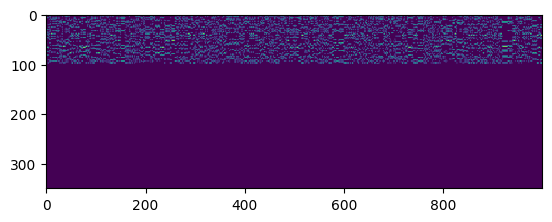

In [18]:
plt.imshow(np.array(network.activity_recordings["ctx"])[network.sleep_indices_A][-1000:].reshape((-1, 350)).T)

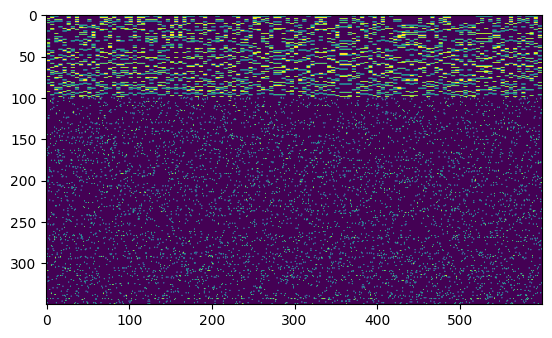

In [27]:
plt.imshow(np.array(network.activity_recordings["ctx"])[network.awake_indices][-1000:-400].reshape((-1, 350)).T)

In [26]:
np.array(network.activity_recordings["ctx"])[network.sleep_indices_A][-15]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

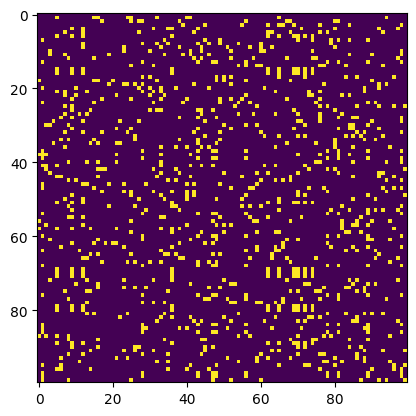

In [39]:
plt.imshow( np.array(network.activity_recordings["mtl_sparse"])[order_mtl_sparse_ctx_A].reshape((-1, 100)))

Text(0.5, 0, 'Time')

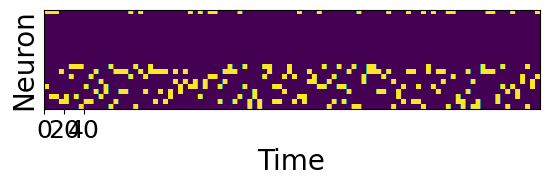

In [27]:
plt.imshow(np.array(network.activity_recordings["mtl"])[network.awake_indices][-500:, 100:][: ,order_mtl_sparse_ctx_A].reshape(-1, 100).T)

plt.yticks([])
plt.xticks([0, 20, 40], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)

Text(0.5, 0, 'Time')

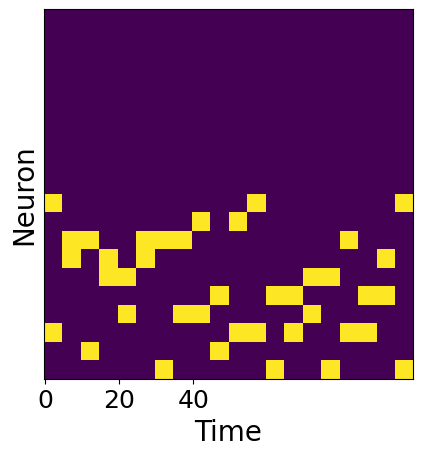

In [66]:
plt.imshow(np.array(network.activity_recordings["mtl"])[network.awake_indices][-100:, 100:][: ,order_mtl_sparse_ctx_A].reshape(-1, 100).T)

plt.yticks([])
plt.xticks([0, 20, 40], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)

Text(0.5, 0, 'Time')

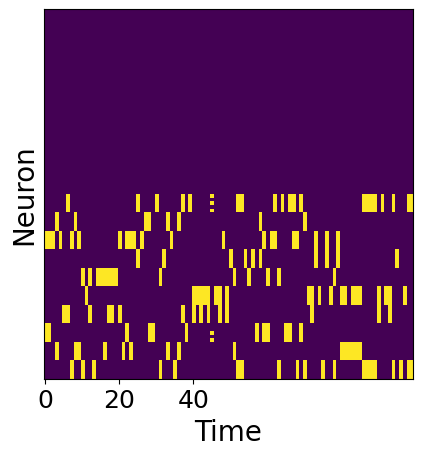

In [71]:
plt.imshow(np.array(network.activity_recordings["mtl"])[network.sleep_indices_A][-400:-300, 100:][: ,order_mtl_sparse_ctx_A].reshape(-1, 100).T)

plt.yticks([])
plt.xticks([0, 20, 40], fontsize=18)
plt.ylabel("Neuron", fontsize=20)
plt.xlabel("Time", fontsize=20)

In [60]:
np.array(network.activity_recordings["mtl"])[network.awake_indices][-1, 100:].sum()

10.0